# Importing all the libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import sklearn.metrics as metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


from keras.layers import Flatten
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPool1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.constraints import max_norm
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve
from keras.utils.vis_utils import plot_model

In [2]:
#Importing the datasets


train_1 = pd.read_csv('admissions.csv')
train_2 = pd.read_csv('vitals.csv')   
test_1 = pd.read_csv('vitals_test.csv')
test_2 = pd.read_csv('admissions_test.csv')   

In [3]:
#merging both datasets on HADM_ID
train_dataset = pd.merge(train_1,train_2, on='HADM_ID')
test_dataset = pd.merge(test_1,test_2, on='HADM_ID')

In [4]:
train_dataset.head()

,HADM_ID,Height,GCS_Eye,GCS_motor,GCS_verbal,ADMISSION_TYPE,ETHNICITY,GENDER,FIRST_CAREUNIT,AGE,...,Fraction_inspired_oxygen,Glucose,Heart_Rate,Mean_blood_pressure,Oxygen_saturation,pH,Respiratory_rate,Systolic_blood_pressure,Temperature,Weight
0,10467,NaN,4.0,6.0,5.0,EMERGENCY,WHITE,0,MICU,35.49863,...,NaN,NaN,NaN,NaN,NaN,7.478685,NaN,NaN,37.788000,NaN
1,10467,NaN,4.0,6.0,5.0,EMERGENCY,WHITE,0,MICU,35.49863,...,55.850864,NaN,NaN,80.549288,NaN,NaN,NaN,NaN,NaN,NaN
2,10467,NaN,4.0,6.0,5.0,EMERGENCY,WHITE,0,MICU,35.49863,...,NaN,151.813514,NaN,NaN,NaN,NaN,NaN,125.697670,36.634106,NaN
3,10467,NaN,4.0,6.0,5.0,EMERGENCY,WHITE,0,MICU,35.49863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.322643
4,10467,NaN,4.0,6.0,5.0,EMERGENCY,WHITE,0,MICU,35.49863,...,54.802035,NaN,77.723207,NaN,96.837797,NaN,NaN,105.314729,NaN,NaN


In [5]:
test_dataset.head()

,HADM_ID,CHART_TIME_STEP_HR,Diastolic_blood_pressure,Fraction_inspired_oxygen,Glucose,Heart_Rate,Mean_blood_pressure,Oxygen_saturation,pH,Respiratory_rate,...,Weight,Height,GCS_Eye,GCS_motor,GCS_verbal,ADMISSION_TYPE,ETHNICITY,GENDER,FIRST_CAREUNIT,AGE
0,10482,0,NaN,NaN,177.283750,NaN,NaN,NaN,7.249081,13.480925,...,49.765461,137.08,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945
1,10482,1,74.134059,NaN,116.124146,97.910453,77.959258,94.637154,7.364961,13.876098,...,NaN,137.08,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945
2,10482,2,61.200316,NaN,205.903217,NaN,NaN,97.637158,NaN,18.619447,...,NaN,137.08,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945
3,10482,3,NaN,NaN,93.615694,79.903595,78.008654,100.174864,NaN,20.437194,...,NaN,137.08,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945
4,10482,4,NaN,59.905487,177.625044,87.614991,82.082165,100.096492,NaN,19.957419,...,NaN,137.08,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945


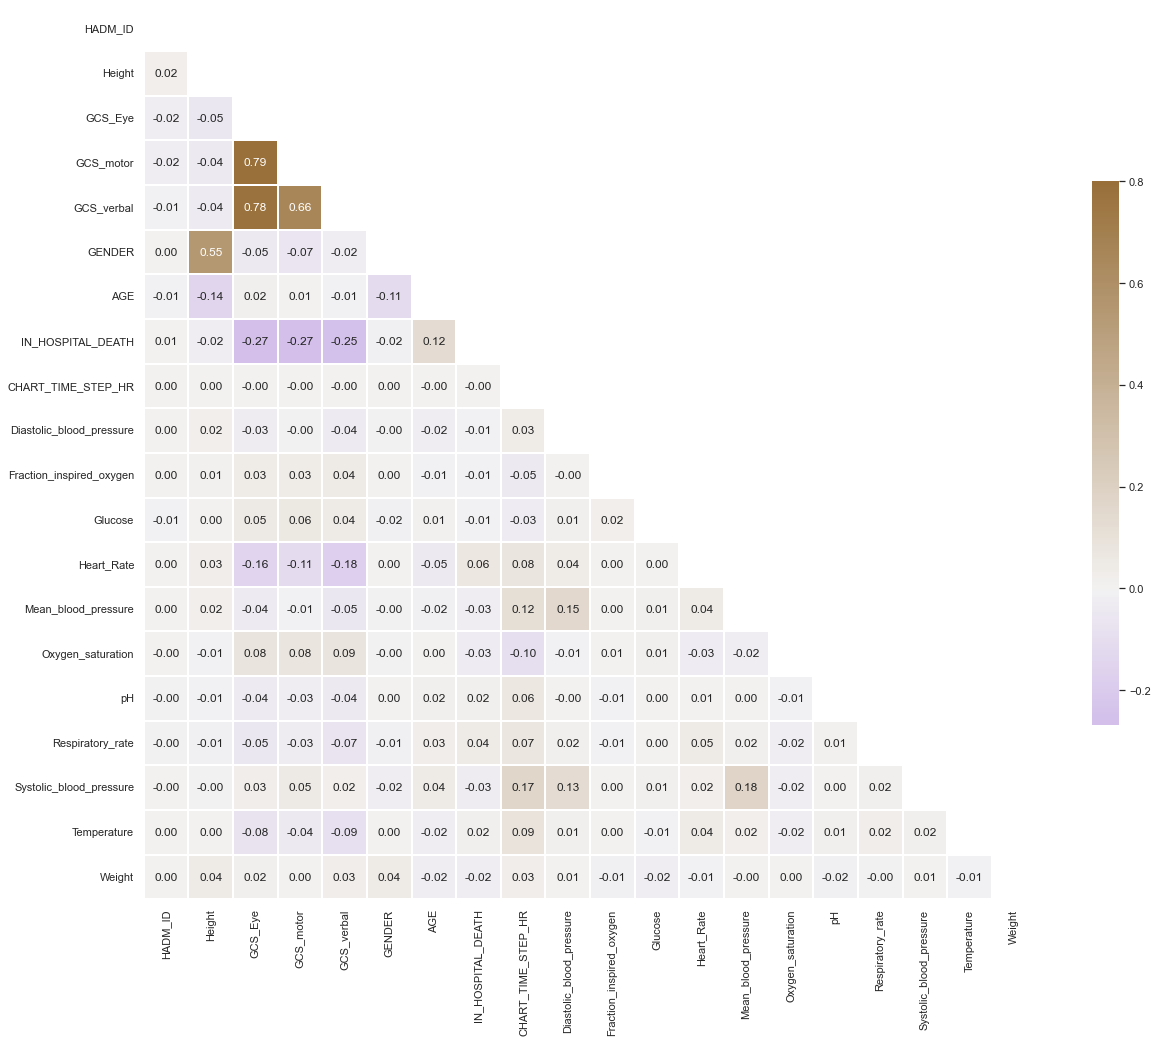

In [6]:
sns.set(style="white")
corr = train_dataset.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20,20))
cmap = sns.diverging_palette(1000, 50, as_cmap=True)
sns.heatmap(corr,annot=True, mask=mask,vmax =.8, cmap=cmap, center=0,fmt= '.2f',
            square=True, linewidths=.1, cbar_kws={"shrink": .5});

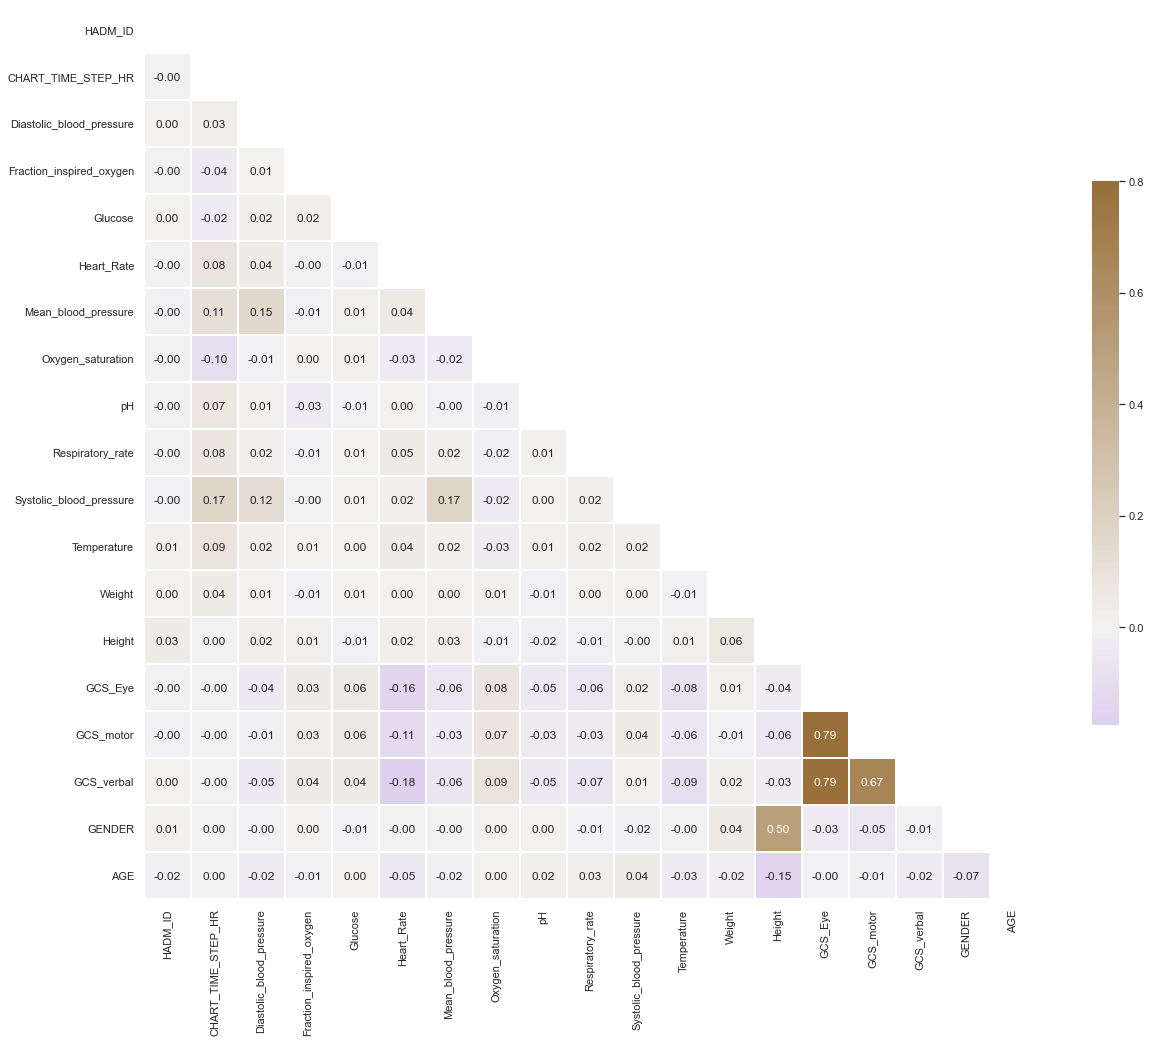

In [7]:
sns.set(style="white")
corr = test_dataset.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20,20))
cmap = sns.diverging_palette(1000, 50, as_cmap=True)
sns.heatmap(corr,annot=True, mask=mask,vmax =.8, cmap=cmap, center=0,fmt= '.2f',
            square=True, linewidths=.1, cbar_kws={"shrink": .5});

In [42]:
n_obs_tst = train_dataset.shape[0]
train_dataset.isna().sum()/n_obs_tst

HADM_ID                     0.000000
Height                      0.808913
GCS_Eye                     0.000362
GCS_motor                   0.000672
GCS_verbal                  0.000465
ADMISSION_TYPE              0.000000
ETHNICITY                   0.000000
GENDER                      0.000000
FIRST_CAREUNIT              0.000000
AGE                         0.000000
IN_HOSPITAL_DEATH           0.000000
CHART_TIME_STEP_HR          0.000000
Diastolic_blood_pressure    0.263996
Fraction_inspired_oxygen    0.880626
Glucose                     0.789626
Heart_Rate                  0.242903
Mean_blood_pressure         0.252336
Oxygen_saturation           0.277549
pH                          0.854873
Respiratory_rate            0.247691
Systolic_blood_pressure     0.253796
Temperature                 0.729326
Weight                      0.906899
dtype: float64

In [8]:
dataset_for_train = train_dataset.groupby(['HADM_ID']).mean()
dataset_for_train.head()


,Height,GCS_Eye,GCS_motor,GCS_verbal,GENDER,AGE,IN_HOSPITAL_DEATH,CHART_TIME_STEP_HR,Diastolic_blood_pressure,Fraction_inspired_oxygen,Glucose,Heart_Rate,Mean_blood_pressure,Oxygen_saturation,pH,Respiratory_rate,Systolic_blood_pressure,Temperature,Weight
HADM_ID,,,,,,,,,,,,,,,,,,,
10467,NaN,4.0,6.0,5.0,0.0,35.498630,0.0,23.5,56.884466,54.097605,143.966146,83.863879,73.251399,97.638652,7.379590,17.580877,110.294635,37.184161,77.320851
10469,NaN,4.0,6.0,5.0,1.0,59.950685,0.0,23.5,58.393333,55.143953,138.432298,83.592969,75.809291,96.834015,7.369573,18.480680,122.355989,36.750291,83.337021
10472,NaN,4.0,6.0,5.0,0.0,48.947945,0.0,23.5,60.269956,55.022174,138.737269,82.022313,82.698045,96.967526,7.322315,19.075493,123.111122,36.987771,81.266352
10475,182.94,3.0,4.0,3.0,1.0,60.835616,0.0,23.5,60.813069,53.946962,132.399276,80.974810,74.618466,97.752003,7.352379,17.910770,116.905367,36.966870,83.327855
10476,NaN,4.0,6.0,5.0,0.0,54.556164,0.0,23.5,60.461719,55.209211,135.470892,85.354083,75.785511,97.052243,7.338809,19.035773,116.705165,36.908203,79.879893


In [9]:
columns_toAdd = train_1[["HADM_ID","ADMISSION_TYPE","ETHNICITY", "FIRST_CAREUNIT"]]
columns_toAdd.head()

,HADM_ID,ADMISSION_TYPE,ETHNICITY,FIRST_CAREUNIT
0,10467,EMERGENCY,WHITE,MICU
1,10469,EMERGENCY,WHITE,MICU
2,10472,EMERGENCY,BLACK,MICU
3,10475,EMERGENCY,WHITE,CSRU
4,10476,ELECTIVE,WHITE,SICU


In [10]:
dataset_for_train = pd.merge(dataset_for_train,columns_toAdd, on='HADM_ID')
dataset_for_train.head()

,HADM_ID,Height,GCS_Eye,GCS_motor,GCS_verbal,GENDER,AGE,IN_HOSPITAL_DEATH,CHART_TIME_STEP_HR,Diastolic_blood_pressure,...,Mean_blood_pressure,Oxygen_saturation,pH,Respiratory_rate,Systolic_blood_pressure,Temperature,Weight,ADMISSION_TYPE,ETHNICITY,FIRST_CAREUNIT
0,10467,NaN,4.0,6.0,5.0,0.0,35.498630,0.0,23.5,56.884466,...,73.251399,97.638652,7.379590,17.580877,110.294635,37.184161,77.320851,EMERGENCY,WHITE,MICU
1,10469,NaN,4.0,6.0,5.0,1.0,59.950685,0.0,23.5,58.393333,...,75.809291,96.834015,7.369573,18.480680,122.355989,36.750291,83.337021,EMERGENCY,WHITE,MICU
2,10472,NaN,4.0,6.0,5.0,0.0,48.947945,0.0,23.5,60.269956,...,82.698045,96.967526,7.322315,19.075493,123.111122,36.987771,81.266352,EMERGENCY,BLACK,MICU
3,10475,182.94,3.0,4.0,3.0,1.0,60.835616,0.0,23.5,60.813069,...,74.618466,97.752003,7.352379,17.910770,116.905367,36.966870,83.327855,EMERGENCY,WHITE,CSRU
4,10476,NaN,4.0,6.0,5.0,0.0,54.556164,0.0,23.5,60.461719,...,75.785511,97.052243,7.338809,19.035773,116.705165,36.908203,79.879893,ELECTIVE,WHITE,SICU


In [11]:
n_obs_tst = dataset_for_train.shape[0]
dataset_for_train.isna().sum()/n_obs_tst

HADM_ID                     0.000000
Height                      0.808913
GCS_Eye                     0.000362
GCS_motor                   0.000672
GCS_verbal                  0.000465
GENDER                      0.000000
AGE                         0.000000
IN_HOSPITAL_DEATH           0.000000
CHART_TIME_STEP_HR          0.000000
Diastolic_blood_pressure    0.000000
Fraction_inspired_oxygen    0.002585
Glucose                     0.000000
Heart_Rate                  0.000000
Mean_blood_pressure         0.000000
Oxygen_saturation           0.000000
pH                          0.001137
Respiratory_rate            0.000000
Systolic_blood_pressure     0.000000
Temperature                 0.000000
Weight                      0.012046
ADMISSION_TYPE              0.000000
ETHNICITY                   0.000000
FIRST_CAREUNIT              0.000000
dtype: float64

Notice that the level of missingness of the *Height* variable is almost 80\%, so it is sensible to drop that variable.

In [12]:
dataset_for_train.drop(columns=['Height', 'CHART_TIME_STEP_HR'], inplace=True)


From now we will only use Train dataset for checking the best model prediction by split method. 

In [13]:
X = dataset_for_train.copy()
X.drop(columns = ['IN_HOSPITAL_DEATH', 'HADM_ID'], inplace = True)

y = dataset_for_train.iloc[:, 6] 

In [14]:
X.head()

,GCS_Eye,GCS_motor,GCS_verbal,GENDER,AGE,Diastolic_blood_pressure,Fraction_inspired_oxygen,Glucose,Heart_Rate,Mean_blood_pressure,Oxygen_saturation,pH,Respiratory_rate,Systolic_blood_pressure,Temperature,Weight,ADMISSION_TYPE,ETHNICITY,FIRST_CAREUNIT
0,4.0,6.0,5.0,0.0,35.498630,56.884466,54.097605,143.966146,83.863879,73.251399,97.638652,7.379590,17.580877,110.294635,37.184161,77.320851,EMERGENCY,WHITE,MICU
1,4.0,6.0,5.0,1.0,59.950685,58.393333,55.143953,138.432298,83.592969,75.809291,96.834015,7.369573,18.480680,122.355989,36.750291,83.337021,EMERGENCY,WHITE,MICU
2,4.0,6.0,5.0,0.0,48.947945,60.269956,55.022174,138.737269,82.022313,82.698045,96.967526,7.322315,19.075493,123.111122,36.987771,81.266352,EMERGENCY,BLACK,MICU
3,3.0,4.0,3.0,1.0,60.835616,60.813069,53.946962,132.399276,80.974810,74.618466,97.752003,7.352379,17.910770,116.905367,36.966870,83.327855,EMERGENCY,WHITE,CSRU
4,4.0,6.0,5.0,0.0,54.556164,60.461719,55.209211,135.470892,85.354083,75.785511,97.052243,7.338809,19.035773,116.705165,36.908203,79.879893,ELECTIVE,WHITE,SICU


In [15]:
X.shape

(19342, 19)

In [16]:
y.shape

(19342,)

,counts,percentage
0.0,17582,90.900631
1.0,1760,9.099369


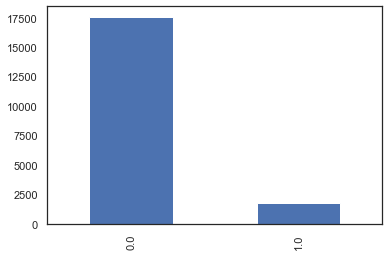

In [17]:
y.value_counts().plot(kind='bar')
pd.concat([y.value_counts(), 
                y.value_counts(normalize=True).mul(100)],axis=1, keys=('counts','percentage'))

In [18]:
X.isna().sum() 

GCS_Eye                       7
GCS_motor                    13
GCS_verbal                    9
GENDER                        0
AGE                           0
Diastolic_blood_pressure      0
Fraction_inspired_oxygen     50
Glucose                       0
Heart_Rate                    0
Mean_blood_pressure           0
Oxygen_saturation             0
pH                           22
Respiratory_rate              0
Systolic_blood_pressure       0
Temperature                   0
Weight                      233
ADMISSION_TYPE                0
ETHNICITY                     0
FIRST_CAREUNIT                0
dtype: int64

We can see the missing value proportion seems to low. Lets check skewness of data

In [19]:
y.value_counts()

0.0    17582
1.0     1760
Name: IN_HOSPITAL_DEATH, dtype: int64

We can see that our data is Imbalanced/skewed. So its hard to predict more positive values with this dataset

Now, our dataset is ready to go for scaling part. Before scaling the data we convert the categorical variable to float. 

In [20]:

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [16,17,18])], remainder='passthrough')
X = np.array(ct.fit_transform(X))


To deal with missing values, we used Simple mean Imputer

In [21]:

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X[:])
X[:] = imputer.transform(X[:])

Now, we will use standard scaler to scale the data

In [22]:

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

We are done with pro-processing. Lets split the data and apply algorithm to find the best model

In [23]:
from sklearn.model_selection import train_test_split
X_train_nm, X_test_nm, y_train_nm, y_test_nm = train_test_split(X, y, test_size = 0.2, random_state = 42)

Lets check the shape of all to verify. 


In [24]:
X_train_nm.shape

(15473, 29)

In [25]:
y_train_nm.shape

(15473,)

In [26]:
X_test_nm.shape

(3869, 29)

In [27]:
y_train_nm.shape

(15473,)

We will use GridSearch for hypertunning to get the best parameters and use the same to predict the values.

In [28]:


n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]



In [29]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

rf_Model = RandomForestClassifier()

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


As we define all the parameter now we will fit into GridSearch to use for our train dataset

In [30]:

rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid,
                       cv = 3, verbose=2, n_jobs = 4)

In [31]:
rf_Grid.fit(X_train_nm, y_train_nm)


Fitting 3 folds for each of 160 candidates, totalling 480 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=2)

In [32]:
print(rf_Grid.best_params_)
print(rf_Grid.score(X_test_nm,y_test_nm))



{'bootstrap': False, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80}
0.9054019126389248


Now we got our best parameter and the score with the best parameter. This score shows that we got 90% accuracy with the best parameter which is good. Lets check with confusion matrix and other techniques

In [33]:
y_pred =rf_Grid.predict(X_test_nm)

In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test_nm, y_pred)
print(cm)
accuracy_score(y_test_nm, y_pred)
from sklearn.metrics import classification_report
matrix = classification_report(y_test_nm,y_pred,labels=[1,0])
print('Classification report : \n',matrix)
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_nm,y_pred)

[[3448   34]
 [ 332   55]]
Classification report : 
               precision    recall  f1-score   support

           1       0.62      0.14      0.23       387
           0       0.91      0.99      0.95      3482

    accuracy                           0.91      3869
   macro avg       0.77      0.57      0.59      3869
weighted avg       0.88      0.91      0.88      3869



0.566177179944996

We can see that the accuracy is the only factor which is good. However the F1 score, recall is bad for positive value (1). Our ROC_AUC score is also near to 57. Lets try to find optimal threshold (default is 0.5) and use the threshold on predicted probabilities.(This type we will predict probability to use threshold)

In [35]:

def threshold_search(y_true, y_proba, plot=False):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    thresholds = np.append(thresholds, 1.001) 
    F = 2 / (1/precision + 1/recall)
    best_score = np.max(F)
    best_th = thresholds[np.argmax(F)]
    if plot:
        plt.plot(thresholds, F, '-b')
        plt.plot([best_th], [best_score], '*r')
        plt.show()
    search_result = {'threshold': best_th , 'f1': best_score}
    return search_result 

In [36]:
y_pred_rf = rf_Grid.predict_proba(X_test_nm)

In [37]:
optimal = threshold_search(y_test_nm, y_pred_rf[:,1])

optimal

C:\Users\DELL\AppData\Local\Temp/ipykernel_24568/3721149385.py:4: RuntimeWarning: divide by zero encountered in true_divide
  F = 2 / (1/precision + 1/recall)


{'threshold': 0.21041666666666664, 'f1': 0.4670391061452514}

0.8422013841580249


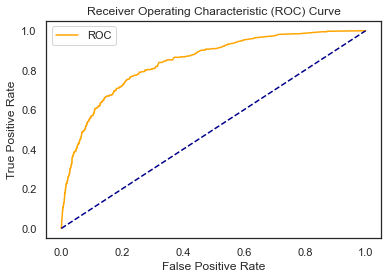

In [41]:

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

y_true = np.array([0,0, 1, 1,1])
y_scores = np.array([0.0,0.09, .05, .75,1])

y_pred_rf = rf_Grid.predict_proba(X_test_nm)
fpr, tpr, thresholds = metrics.roc_curve(y_test_nm,  y_pred_rf[:,1])

print(roc_auc_score(y_test_nm,  y_pred_rf[:,1]))
optimal_idx = np.argmax(tpr - fpr)

plot_roc_curve(fpr, tpr)


We can see that if we use the optimal threshold 0.222 we will get the F1 score as 0.47 which is much more improved. Lets see

In [36]:
threshold = 0.2222222222222


predicted = (y_pred_rf [:,1] >= threshold).astype('int')

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test_nm, predicted)
print(cm)
accuracy_score(y_test_nm, predicted)
from sklearn.metrics import classification_report
matrix = classification_report(y_test_nm,predicted,labels=[1,0])
print('Classification report : \n',matrix)
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_nm,predicted)

[[3214  268]
 [ 189  198]]
Classification report : 
               precision    recall  f1-score   support

           1       0.42      0.51      0.46       387
           0       0.94      0.92      0.93      3482

    accuracy                           0.88      3869
   macro avg       0.68      0.72      0.70      3869
weighted avg       0.89      0.88      0.89      3869



0.7173303233907271

We will use this parameter and same architecture on our Original Test data in the last. Now, lets move to deep learning we will use LSTM because it seems to be best on time-series data. Before moving to LSTM we have to work on our dataset to prepare it for LSTM.  We will use the old dataset (without merging by mean) with 928416 rows and covert it into three-dimensional array as LSTM accept 3 dimensional input

In [38]:
train_dataset.shape

(928416, 23)

We will again follow the pre-processing steps - cleaning, missing values, scaling, converting categorical variable to float 

In [39]:
n_obs_tst = train_dataset.shape[0]
train_dataset.isna().sum()/n_obs_tst

HADM_ID                     0.000000
Height                      0.808913
GCS_Eye                     0.000362
GCS_motor                   0.000672
GCS_verbal                  0.000465
ADMISSION_TYPE              0.000000
ETHNICITY                   0.000000
GENDER                      0.000000
FIRST_CAREUNIT              0.000000
AGE                         0.000000
IN_HOSPITAL_DEATH           0.000000
CHART_TIME_STEP_HR          0.000000
Diastolic_blood_pressure    0.263996
Fraction_inspired_oxygen    0.880626
Glucose                     0.789626
Heart_Rate                  0.242903
Mean_blood_pressure         0.252336
Oxygen_saturation           0.277549
pH                          0.854873
Respiratory_rate            0.247691
Systolic_blood_pressure     0.253796
Temperature                 0.729326
Weight                      0.906899
dtype: float64

This type we have to drop all the columns which has more than 70% missing values. 

In [40]:
train_dataset.drop(columns=['Height', 'Fraction_inspired_oxygen', 'Glucose', 'pH', 'Weight', 'Temperature','CHART_TIME_STEP_HR'], inplace=True)


In [41]:
train_dataset.head()

,HADM_ID,GCS_Eye,GCS_motor,GCS_verbal,ADMISSION_TYPE,ETHNICITY,GENDER,FIRST_CAREUNIT,AGE,IN_HOSPITAL_DEATH,Diastolic_blood_pressure,Heart_Rate,Mean_blood_pressure,Oxygen_saturation,Respiratory_rate,Systolic_blood_pressure
0,10467,4.0,6.0,5.0,EMERGENCY,WHITE,0,MICU,35.49863,0,NaN,NaN,NaN,NaN,NaN,NaN
1,10467,4.0,6.0,5.0,EMERGENCY,WHITE,0,MICU,35.49863,0,65.57345,NaN,80.549288,NaN,NaN,NaN
2,10467,4.0,6.0,5.0,EMERGENCY,WHITE,0,MICU,35.49863,0,NaN,NaN,NaN,NaN,NaN,125.697670
3,10467,4.0,6.0,5.0,EMERGENCY,WHITE,0,MICU,35.49863,0,NaN,NaN,NaN,NaN,NaN,NaN
4,10467,4.0,6.0,5.0,EMERGENCY,WHITE,0,MICU,35.49863,0,NaN,77.723207,NaN,96.837797,NaN,105.314729


In [42]:
X_ts = train_dataset.copy()
X_ts.drop(columns = ['IN_HOSPITAL_DEATH', 'HADM_ID'], inplace = True)



We will use sam old y as our target variable doesn't change it will be same for 19342 patients. We will create copy of our old Y to avoid confusion

In [43]:
y_ts = y.copy()

In [44]:
y_ts.shape

(19342,)

In [45]:
X_ts.shape

(928416, 14)

In [46]:
n_obs_X = X_ts.shape[0]
X_ts.isna().sum()/n_obs_X

GCS_Eye                     0.000362
GCS_motor                   0.000672
GCS_verbal                  0.000465
ADMISSION_TYPE              0.000000
ETHNICITY                   0.000000
GENDER                      0.000000
FIRST_CAREUNIT              0.000000
AGE                         0.000000
Diastolic_blood_pressure    0.263996
Heart_Rate                  0.242903
Mean_blood_pressure         0.252336
Oxygen_saturation           0.277549
Respiratory_rate            0.247691
Systolic_blood_pressure     0.253796
dtype: float64

For others we can use Mean imputer to deal with missing values

In [47]:

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [3,4,6])], remainder='passthrough')
X_ts = np.array(ct.fit_transform(X_ts))


#To deal with missing values, we used Simple mean Imputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X_ts[:])
X_ts[:] = imputer.transform(X_ts[:])

#Now, we will use standard scaler to scale the data


scaler = StandardScaler().fit(X_ts)
X_ts = scaler.transform(X_ts)

In [48]:
X_ts.shape

(928416, 24)

Lets reshape the data to 3 dimensional 

In [49]:
X_new_reshape  = X_ts.reshape((19342, 48, 24))

In [50]:
y_new = np.array(y_ts)

In [51]:
X_new_reshape.shape

(19342, 48, 24)

In [52]:
y_new.shape

(19342,)

Here we will use normal split to keep the time-series sequence

In [53]:
trn_size = 0.8
trn_idx = int(len(X_new_reshape) * trn_size)
X_train, X_test = X_new_reshape[0:trn_idx], X_new_reshape[trn_idx:len(X_new_reshape)]

In [54]:

y_train, y_test = y_new[0:trn_idx], y_new[trn_idx:len(y_new)]

In [55]:
X_train.shape

(15473, 48, 24)

In [56]:
X_test.shape

(3869, 48, 24)

In [57]:
y_train.shape

(15473,)

In [58]:
y_test.shape

(3869,)

In [59]:
model = Sequential()
model.add(LSTM(256, input_shape = (48,24)))


model.add(Dropout(0.2))

model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               287744    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 288,001
Trainable params: 288,001
Non-trainable params: 0
_________________________________________________________________


Our model architecture is ready, now we will use binary_crossentropy loss function as it is suitable for our problem to run the model 

In [60]:
model.compile(loss='binary_crossentropy', optimizer='adam')

history = model.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
484/484 [==============================] - 43s 89ms/step - loss: 0.9142
Epoch 2/10
484/484 [==============================] - 36s 75ms/step - loss: 0.9885
Epoch 3/10
484/484 [==============================] - 35s 73ms/step - loss: 1.2090
Epoch 4/10
484/484 [==============================] - 35s 72ms/step - loss: 1.1552
Epoch 5/10
484/484 [==============================] - 34s 71ms/step - loss: 1.1069
Epoch 6/10
484/484 [==============================] - 36s 73ms/step - loss: 0.8467
Epoch 7/10
484/484 [==============================] - 37s 76ms/step - loss: 1.3002
Epoch 8/10
484/484 [==============================] - 35s 72ms/step - loss: 1.1181
Epoch 9/10
484/484 [==============================] - 35s 72ms/step - loss: 1.1456
Epoch 10/10
484/484 [==============================] - 34s 70ms/step - loss: 0.6477


Lets plot the model loss on graph to visualise it properly

Text(0, 0.5, "['loss']")

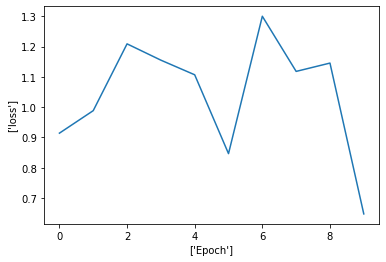

In [61]:
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])
plt.xlabel(['Epoch'])
plt.ylabel(['loss'])

In [62]:
model.evaluate(X_train, y_train)

484/484 [==============================] - 14s 29ms/step - loss: 0.5631


0.563078761100769

In [63]:
model.evaluate(X_test, y_test)

121/121 [==============================] - 3s 28ms/step - loss: 0.5591


0.5591065287590027

In [64]:
seq_predictions=model.predict(X_test)
seq_predictions

array([[-0.586305  ],
       [-0.10329291],
       [-1.9192839 ],
       ...,
       [-0.75172716],
       [ 0.15389568],
       [-0.03629659]], dtype=float32)

In [65]:
optimal = threshold_search(y_test, seq_predictions)
optimal

C:\Users\DELL\AppData\Local\Temp/ipykernel_12164/3721149385.py:4: RuntimeWarning: divide by zero encountered in true_divide
  F = 2 / (1/precision + 1/recall)


{'threshold': 0.2540298402309418, 'f1': 0.4621733149931224}

In [66]:
threshold = 0.3 #changes everytime with optimal threshold value
seq_predictions=model.predict(X_test)
print('Outputs shape')    
print(seq_predictions.shape) # prints (n,1) but  need (n,)
seq_predictions=np.transpose(seq_predictions)[0]  # transformation to get (n,)
print(seq_predictions.shape)  # now the shape is (n,)
# Applying transformation to get binary values predictions with thresold
seq_predictions = list(map(lambda x: 0 if x<threshold else 1, seq_predictions))

Outputs shape
(3869, 1)
(3869,)


In [67]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, seq_predictions)
print(cm)
accuracy_score(y_test, seq_predictions)
from sklearn.metrics import classification_report
matrix = classification_report(y_test,seq_predictions,labels=[1,0])
print('Classification report : \n',matrix)
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,seq_predictions)

[[3346  161]
 [ 216  146]]
Classification report : 
               precision    recall  f1-score   support

           1       0.48      0.40      0.44       362
           0       0.94      0.95      0.95      3507

    accuracy                           0.90      3869
   macro avg       0.71      0.68      0.69      3869
weighted avg       0.90      0.90      0.90      3869



0.6787033667471687

Now, lets plot ROC_AUC Curve

0.8130164296505648


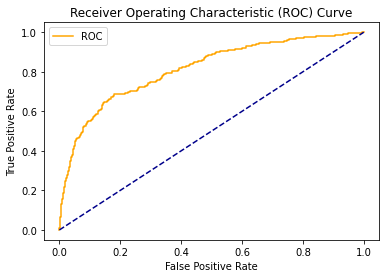

In [68]:

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

y_true = np.array([0,0, 1, 1,1])
y_scores = np.array([0.0,0.09, .05, .75,1])

seq_predictions=model.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, seq_predictions)

print(roc_auc_score(y_test, seq_predictions))
optimal_idx = np.argmax(tpr - fpr)

plot_roc_curve(fpr, tpr)


We can see that our score is increase to 48. Now lets try the model with sigmoid activation function which suits for binary problem

In [69]:
model_1 = Sequential()
model_1.add(LSTM(256, input_shape = (48,24)))


model_1.add(Dropout(0.2))

model_1.add(Dense(1, activation = 'sigmoid'))
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               287744    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 288,001
Trainable params: 288,001
Non-trainable params: 0
_________________________________________________________________


In [70]:
model_1.compile(loss='binary_crossentropy', optimizer='adam')

history = model_1.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
484/484 [==============================] - 35s 71ms/step - loss: 0.2505
Epoch 2/10
484/484 [==============================] - 35s 72ms/step - loss: 0.2294
Epoch 3/10
484/484 [==============================] - 34s 71ms/step - loss: 0.2253
Epoch 4/10
484/484 [==============================] - 35s 72ms/step - loss: 0.2148
Epoch 5/10
484/484 [==============================] - 304s 628ms/step - loss: 0.2029
Epoch 6/10
484/484 [==============================] - 30s 63ms/step - loss: 0.1957
Epoch 7/10
484/484 [==============================] - 33s 69ms/step - loss: 0.1886
Epoch 8/10
484/484 [==============================] - 34s 70ms/step - loss: 0.1811
Epoch 9/10
484/484 [==============================] - 33s 68ms/step - loss: 0.1729
Epoch 10/10
484/484 [==============================] - 33s 68ms/step - loss: 0.1673


Text(0, 0.5, "['loss']")

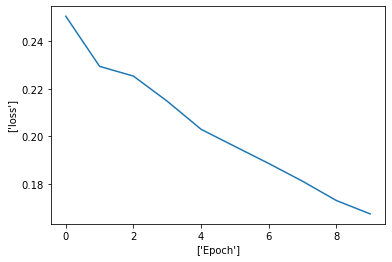

In [71]:
plt.plot(range(len(model_1.history.history['loss'])), model_1.history.history['loss'])
plt.xlabel(['Epoch'])
plt.ylabel(['loss'])

In [72]:
model_1.evaluate(X_train, y_train)

484/484 [==============================] - 14s 29ms/step - loss: 0.1499


0.1498895138502121

In [73]:
model_1.evaluate(X_test, y_test)

121/121 [==============================] - 3s 28ms/step - loss: 0.1933


0.19326993823051453

In [74]:
seq_predictions_1=model_1.predict(X_test)
seq_predictions_1

array([[0.01204166],
       [0.06639701],
       [0.00152633],
       ...,
       [0.00369146],
       [0.02114755],
       [0.00505325]], dtype=float32)

In [75]:
optimal = threshold_search(y_test, seq_predictions_1)
optimal

C:\Users\DELL\AppData\Local\Temp/ipykernel_12164/3721149385.py:4: RuntimeWarning: divide by zero encountered in true_divide
  F = 2 / (1/precision + 1/recall)


{'threshold': 0.4333048462867737, 'f1': 0.5787878787878789}

In [76]:
threshold = 0.3  #changes with optimal value
seq_predictions_1=model_1.predict(X_test)
print('Outputs shape')    
print(seq_predictions_1.shape) # prints (n,1) but  need (n,)
seq_predictions_1=np.transpose(seq_predictions_1)[0]  # transformation to get (n,)
print(seq_predictions_1.shape)  # now the shape is (n,)
# Applying transformation to get binary values predictions with  thresold
seq_predictions_1 = list(map(lambda x: 0 if x<threshold else 1, seq_predictions_1))

Outputs shape
(3869, 1)
(3869,)


In [77]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, seq_predictions_1)
print(cm)
accuracy_score(y_test, seq_predictions_1)
from sklearn.metrics import classification_report
matrix = classification_report(y_test,seq_predictions_1,labels=[1,0])
print('Classification report : \n',matrix)
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,seq_predictions_1)

[[3305  202]
 [ 138  224]]
Classification report : 
               precision    recall  f1-score   support

           1       0.53      0.62      0.57       362
           0       0.96      0.94      0.95      3507

    accuracy                           0.91      3869
   macro avg       0.74      0.78      0.76      3869
weighted avg       0.92      0.91      0.92      3869



0.7805927214237666

0.9024437313218865


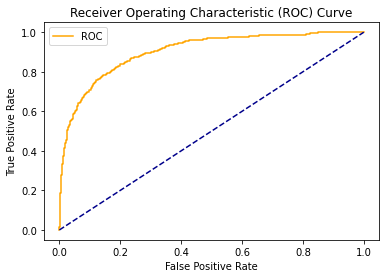

In [78]:
seq_predictions_1=model_1.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, seq_predictions_1)

print(roc_auc_score(y_test, seq_predictions_1))
optimal_idx = np.argmax(tpr - fpr)

plot_roc_curve(fpr, tpr)

We can see that the score improved. After running the model few times we got the F1 score around 48 to 52 We will keep this model for our original data test. Now, lets try CNN

In [153]:
model_2 = Sequential()
model_2.add(Conv1D(filters = 48, kernel_size = 3, padding = 'valid', activation = 'relu' ,input_shape = (48,24)))


model_2.add(Dropout(0.2))
model_2.add(MaxPool1D())

model_2.add(Flatten())


model_2.add(Dense(1, activation = 'sigmoid'))
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 46, 48)            3504      
_________________________________________________________________
dropout_5 (Dropout)          (None, 46, 48)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 48)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1104)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1105      
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


In [80]:
model_2.compile(loss='binary_crossentropy', optimizer='adam')

history = model_2.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
484/484 [==============================] - 1s 2ms/step - loss: 0.2581
Epoch 2/10
484/484 [==============================] - 1s 3ms/step - loss: 0.2398
Epoch 3/10
484/484 [==============================] - 1s 3ms/step - loss: 0.2301
Epoch 4/10
484/484 [==============================] - 1s 3ms/step - loss: 0.2234
Epoch 5/10
484/484 [==============================] - 1s 3ms/step - loss: 0.2193
Epoch 6/10
484/484 [==============================] - 1s 2ms/step - loss: 0.2152
Epoch 7/10
484/484 [==============================] - 1s 2ms/step - loss: 0.2109
Epoch 8/10
484/484 [==============================] - 1s 2ms/step - loss: 0.2070
Epoch 9/10
484/484 [==============================] - 1s 2ms/step - loss: 0.2059
Epoch 10/10
484/484 [==============================] - 1s 2ms/step - loss: 0.2045


Text(0, 0.5, "['loss']")

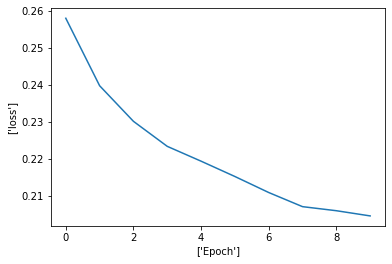

In [81]:
plt.plot(range(len(model_2.history.history['loss'])), model_2.history.history['loss'])
plt.xlabel(['Epoch'])
plt.ylabel(['loss'])

In [82]:
model_2.evaluate(X_train, y_train)

484/484 [==============================] - 0s 857us/step - loss: 0.2033


0.2032792717218399

In [83]:
model_2.evaluate(X_test, y_test)

121/121 [==============================] - 0s 863us/step - loss: 0.2212


0.22118186950683594

In [84]:
seq_predictions_2=model_2.predict(X_test)
seq_predictions_2

array([[0.03869718],
       [0.31103796],
       [0.01219109],
       ...,
       [0.02404609],
       [0.06423494],
       [0.06441185]], dtype=float32)

In [85]:
optimal = threshold_search(y_test, seq_predictions_2)
optimal

C:\Users\DELL\AppData\Local\Temp/ipykernel_12164/3721149385.py:4: RuntimeWarning: divide by zero encountered in true_divide
  F = 2 / (1/precision + 1/recall)


{'threshold': 0.3685990571975708, 'f1': 0.5037037037037037}

In [86]:
threshold = 0.27  #changing with the threshold value everytime
seq_predictions_2=model_2.predict(X_test)
print('Outputs shape')    
print(seq_predictions_2.shape) # prints (n,1) but  need (n,)
seq_predictions_2=np.transpose(seq_predictions_2)[0]  # transformation to get (n,)
print(seq_predictions_2.shape)  # now the shape is (n,)
# Applying transformation to get binary values predictions with thresold
seq_predictions_2 = list(map(lambda x: 0 if x<threshold else 1, seq_predictions_2))

Outputs shape
(3869, 1)
(3869,)


In [87]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, seq_predictions_2)
print(cm)
accuracy_score(y_test, seq_predictions_2)
from sklearn.metrics import classification_report
matrix = classification_report(y_test,seq_predictions_2,labels=[1,0])
print('Classification report : \n',matrix)
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,seq_predictions_2)

[[3228  279]
 [ 152  210]]
Classification report : 
               precision    recall  f1-score   support

           1       0.43      0.58      0.49       362
           0       0.96      0.92      0.94      3507

    accuracy                           0.89      3869
   macro avg       0.69      0.75      0.72      3869
weighted avg       0.91      0.89      0.90      3869



0.7502776609370052

0.8715859520107379


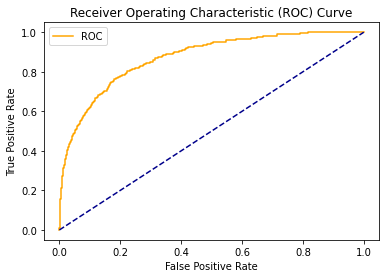

In [88]:

seq_predictions_1=model_2.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, seq_predictions_1)

print(roc_auc_score(y_test, seq_predictions_1))
optimal_idx = np.argmax(tpr - fpr)

plot_roc_curve(fpr, tpr)

The score is bit same with previous one however, it seems good according to precision, recall and ROC_AUC score. We will keep this also. Now we will try CNN with LSTM which is most powerful model and might find better model in our case

In [89]:
model_3=Sequential()
model_3.add(Conv1D(filters = 48, kernel_size = 3, 
                 padding='valid', 
                  activation = 'relu',input_shape=(48, 24)))
  
                        
                                            
                        
model_3.add(Dropout(0.2))

model_3.add(MaxPool1D(pool_size = 2 )) 
model_3.add(LSTM(100, recurrent_activation='hard_sigmoid',
               dropout=0.0, recurrent_dropout=0.0, return_state=False,
               stateful=False, unroll=False))

model_3.add(Dropout(0.2))
model_3.add(Flatten())
model_3.add(Dense(1, activation = 'sigmoid'))
model_3.add(Activation('linear'))
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 46, 48)            3504      
_________________________________________________________________
dropout_3 (Dropout)          (None, 46, 48)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 23, 48)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               59600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

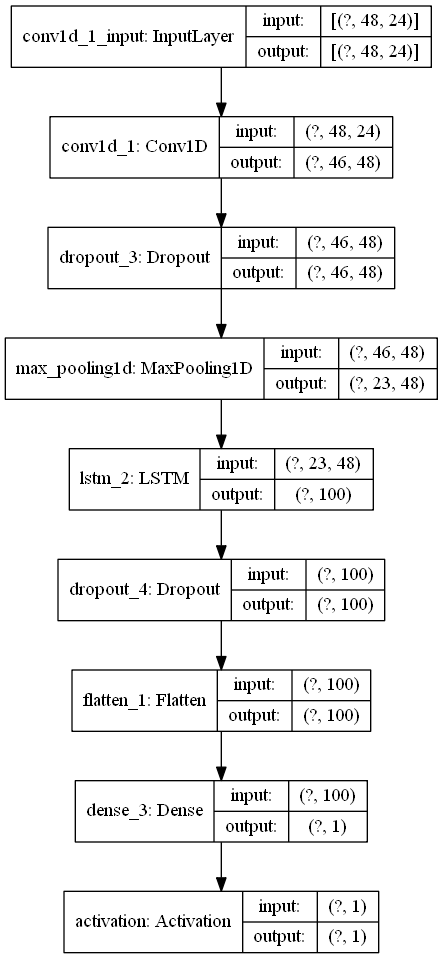

In [161]:
plot_model(model_3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [90]:
model_3.compile(loss='binary_crossentropy', optimizer='adam')

history = model_3.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
484/484 [==============================] - 9s 19ms/step - loss: 0.2441
Epoch 2/10
484/484 [==============================] - 9s 19ms/step - loss: 0.2194
Epoch 3/10
484/484 [==============================] - 9s 19ms/step - loss: 0.2075
Epoch 4/10
484/484 [==============================] - 10s 20ms/step - loss: 0.2014
Epoch 5/10
484/484 [==============================] - 9s 19ms/step - loss: 0.1921
Epoch 6/10
484/484 [==============================] - 9s 19ms/step - loss: 0.1873
Epoch 7/10
484/484 [==============================] - 9s 19ms/step - loss: 0.1855
Epoch 8/10
484/484 [==============================] - 9s 19ms/step - loss: 0.1810
Epoch 9/10
484/484 [==============================] - 9s 19ms/step - loss: 0.1746
Epoch 10/10
484/484 [==============================] - 9s 19ms/step - loss: 0.1757


Text(0, 0.5, "['loss']")

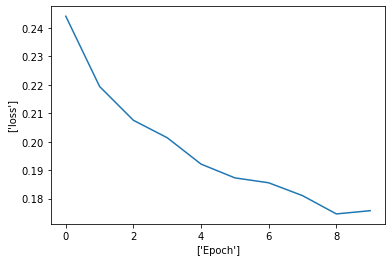

In [91]:
plt.plot(range(len(model_3.history.history['loss'])), model_3.history.history['loss'])
plt.xlabel(['Epoch'])
plt.ylabel(['loss'])

In [92]:
model_3.evaluate(X_train, y_train)

484/484 [==============================] - 2s 3ms/step - loss: 0.1589


0.1589130163192749

In [93]:
model_3.evaluate(X_test, y_test)

121/121 [==============================] - 0s 4ms/step - loss: 0.1883


0.1883295476436615

In [94]:
seq_predictions_3=model_3.predict(X_test)
seq_predictions_3

array([[0.05901852],
       [0.12686065],
       [0.00028217],
       ...,
       [0.00045851],
       [0.00834945],
       [0.00222629]], dtype=float32)

In [95]:
optimal = threshold_search(y_test, seq_predictions_3)
optimal

C:\Users\DELL\AppData\Local\Temp/ipykernel_12164/3721149385.py:4: RuntimeWarning: divide by zero encountered in true_divide
  F = 2 / (1/precision + 1/recall)


{'threshold': 0.3225061893463135, 'f1': 0.6027397260273972}

In [96]:
threshold = 0.2
seq_predictions_3=model_3.predict(X_test)
print('Outputs shape')    
print(seq_predictions_3.shape) # prints (n,1) but  need (n,)
seq_predictions_3=np.transpose(seq_predictions_3)[0]  # transformation to get (n,)
print(seq_predictions_3.shape)  # now the shape is (n,)
# Applying transformation to get binary values predictions with  thresold
seq_predictions_3 = list(map(lambda x: 0 if x<threshold else 1, seq_predictions_3))

Outputs shape
(3869, 1)
(3869,)


In [97]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, seq_predictions_3)
print(cm)
accuracy_score(y_test, seq_predictions_3)
from sklearn.metrics import classification_report
matrix = classification_report(y_test,seq_predictions_3,labels=[1,0])
print('Classification report : \n',matrix)
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,seq_predictions_3)

[[3173  334]
 [ 101  261]]
Classification report : 
               precision    recall  f1-score   support

           1       0.44      0.72      0.55       362
           0       0.97      0.90      0.94      3507

    accuracy                           0.89      3869
   macro avg       0.70      0.81      0.74      3869
weighted avg       0.92      0.89      0.90      3869



0.8128781899500132

0.9116947635904199


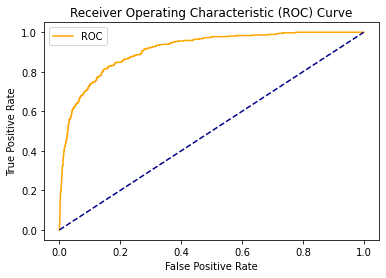

In [98]:

seq_predictions_3 = model_3.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, seq_predictions_3)
#print(tpr)
#print(fpr)
#print(thresholds)
print(roc_auc_score(y_test, seq_predictions_3))
#optimal_idx = np.argmax(tpr - fpr)
#optimal_threshold = thresholds[optimal_idx]
#print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

Now, we will use all this 3 model architecture on our original test data and predict and generate a prediction file

In [99]:
test_dataset.head()

,HADM_ID,CHART_TIME_STEP_HR,Diastolic_blood_pressure,Fraction_inspired_oxygen,Glucose,Heart_Rate,Mean_blood_pressure,Oxygen_saturation,pH,Respiratory_rate,...,Weight,Height,GCS_Eye,GCS_motor,GCS_verbal,ADMISSION_TYPE,ETHNICITY,GENDER,FIRST_CAREUNIT,AGE
0,10482,0,NaN,NaN,177.283750,NaN,NaN,NaN,7.249081,13.480925,...,49.765461,137.08,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945
1,10482,1,74.134059,NaN,116.124146,97.910453,77.959258,94.637154,7.364961,13.876098,...,NaN,137.08,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945
2,10482,2,61.200316,NaN,205.903217,NaN,NaN,97.637158,NaN,18.619447,...,NaN,137.08,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945
3,10482,3,NaN,NaN,93.615694,79.903595,78.008654,100.174864,NaN,20.437194,...,NaN,137.08,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945
4,10482,4,NaN,59.905487,177.625044,87.614991,82.082165,100.096492,NaN,19.957419,...,NaN,137.08,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945


In [100]:
dataset_for_test = test_dataset.groupby(['HADM_ID']).mean()
dataset_for_test.head()


,CHART_TIME_STEP_HR,Diastolic_blood_pressure,Fraction_inspired_oxygen,Glucose,Heart_Rate,Mean_blood_pressure,Oxygen_saturation,pH,Respiratory_rate,Systolic_blood_pressure,Temperature,Weight,Height,GCS_Eye,GCS_motor,GCS_verbal,GENDER,AGE
HADM_ID,,,,,,,,,,,,,,,,,,
10482,23.5,63.400020,57.644481,151.892624,89.584858,81.042940,96.699294,7.356923,19.273598,118.932444,37.188440,77.349404,137.08,3.0,5.0,1.0,1.0,55.547945
10486,23.5,60.764163,54.727844,147.936593,82.852180,76.698210,97.143030,7.356016,18.410208,119.480574,36.925189,86.714986,175.13,4.0,4.0,5.0,1.0,58.616438
10490,23.5,61.239206,55.676815,138.981222,86.230247,78.899087,97.129945,7.368315,18.394566,119.769236,37.049846,83.757621,175.13,4.0,6.0,4.0,1.0,71.361644
10497,23.5,62.293316,54.544267,134.395503,81.485003,80.453078,96.233018,7.376927,18.524180,122.134825,36.948027,79.614192,NaN,3.0,4.0,3.0,0.0,81.482192
10506,23.5,62.483374,54.413401,150.152022,84.844375,76.908570,97.461497,7.350793,19.264295,123.815875,36.916096,79.522429,NaN,4.0,6.0,5.0,1.0,30.572603


In [101]:
columns_toAdd_test = test_2[["HADM_ID","ADMISSION_TYPE","ETHNICITY", "FIRST_CAREUNIT"]]
columns_toAdd_test.head()

,HADM_ID,ADMISSION_TYPE,ETHNICITY,FIRST_CAREUNIT
0,88439,EMERGENCY,WHITE,TSICU
1,85430,EMERGENCY,WHITE,MICU
2,33620,EMERGENCY,BLACK,TSICU
3,108726,EMERGENCY,WHITE,CCU
4,71197,URGENT,ASIAN,MICU


In [102]:
dataset_for_test= pd.merge(dataset_for_test,columns_toAdd_test, on='HADM_ID')
dataset_for_test.head()

,HADM_ID,CHART_TIME_STEP_HR,Diastolic_blood_pressure,Fraction_inspired_oxygen,Glucose,Heart_Rate,Mean_blood_pressure,Oxygen_saturation,pH,Respiratory_rate,...,Weight,Height,GCS_Eye,GCS_motor,GCS_verbal,GENDER,AGE,ADMISSION_TYPE,ETHNICITY,FIRST_CAREUNIT
0,10482,23.5,63.400020,57.644481,151.892624,89.584858,81.042940,96.699294,7.356923,19.273598,...,77.349404,137.08,3.0,5.0,1.0,1.0,55.547945,EMERGENCY,WHITE,MICU
1,10486,23.5,60.764163,54.727844,147.936593,82.852180,76.698210,97.143030,7.356016,18.410208,...,86.714986,175.13,4.0,4.0,5.0,1.0,58.616438,EMERGENCY,WHITE,CCU
2,10490,23.5,61.239206,55.676815,138.981222,86.230247,78.899087,97.129945,7.368315,18.394566,...,83.757621,175.13,4.0,6.0,4.0,1.0,71.361644,ELECTIVE,OTHER,CSRU
3,10497,23.5,62.293316,54.544267,134.395503,81.485003,80.453078,96.233018,7.376927,18.524180,...,79.614192,NaN,3.0,4.0,3.0,0.0,81.482192,ELECTIVE,WHITE,CSRU
4,10506,23.5,62.483374,54.413401,150.152022,84.844375,76.908570,97.461497,7.350793,19.264295,...,79.522429,NaN,4.0,6.0,5.0,1.0,30.572603,EMERGENCY,BLACK,TSICU


In [103]:
n_obs_tst = dataset_for_test.shape[0]
dataset_for_test.isna().sum()/n_obs_tst

HADM_ID                     0.000000
CHART_TIME_STEP_HR          0.000000
Diastolic_blood_pressure    0.000000
Fraction_inspired_oxygen    0.003981
Glucose                     0.000121
Heart_Rate                  0.000000
Mean_blood_pressure         0.000000
Oxygen_saturation           0.000000
pH                          0.001086
Respiratory_rate            0.000000
Systolic_blood_pressure     0.000000
Temperature                 0.000000
Weight                      0.012426
Height                      0.805405
GCS_Eye                     0.000241
GCS_motor                   0.000362
GCS_verbal                  0.000603
GENDER                      0.000000
AGE                         0.000000
ADMISSION_TYPE              0.000000
ETHNICITY                   0.000000
FIRST_CAREUNIT              0.000000
dtype: float64

Notice that the level of missingness of the *Height* variable is almost 80\%, so it is sensible to drop that variable.

In [104]:
dataset_for_test.drop(columns=['Height', 'CHART_TIME_STEP_HR'], inplace=True)


In [105]:
dataset_for_test.head()

,HADM_ID,Diastolic_blood_pressure,Fraction_inspired_oxygen,Glucose,Heart_Rate,Mean_blood_pressure,Oxygen_saturation,pH,Respiratory_rate,Systolic_blood_pressure,Temperature,Weight,GCS_Eye,GCS_motor,GCS_verbal,GENDER,AGE,ADMISSION_TYPE,ETHNICITY,FIRST_CAREUNIT
0,10482,63.400020,57.644481,151.892624,89.584858,81.042940,96.699294,7.356923,19.273598,118.932444,37.188440,77.349404,3.0,5.0,1.0,1.0,55.547945,EMERGENCY,WHITE,MICU
1,10486,60.764163,54.727844,147.936593,82.852180,76.698210,97.143030,7.356016,18.410208,119.480574,36.925189,86.714986,4.0,4.0,5.0,1.0,58.616438,EMERGENCY,WHITE,CCU
2,10490,61.239206,55.676815,138.981222,86.230247,78.899087,97.129945,7.368315,18.394566,119.769236,37.049846,83.757621,4.0,6.0,4.0,1.0,71.361644,ELECTIVE,OTHER,CSRU
3,10497,62.293316,54.544267,134.395503,81.485003,80.453078,96.233018,7.376927,18.524180,122.134825,36.948027,79.614192,3.0,4.0,3.0,0.0,81.482192,ELECTIVE,WHITE,CSRU
4,10506,62.483374,54.413401,150.152022,84.844375,76.908570,97.461497,7.350793,19.264295,123.815875,36.916096,79.522429,4.0,6.0,5.0,1.0,30.572603,EMERGENCY,BLACK,TSICU


In [106]:
dataset_for_train.head()

,HADM_ID,GCS_Eye,GCS_motor,GCS_verbal,GENDER,AGE,IN_HOSPITAL_DEATH,Diastolic_blood_pressure,Fraction_inspired_oxygen,Glucose,...,Mean_blood_pressure,Oxygen_saturation,pH,Respiratory_rate,Systolic_blood_pressure,Temperature,Weight,ADMISSION_TYPE,ETHNICITY,FIRST_CAREUNIT
0,10467,4.0,6.0,5.0,0.0,35.498630,0.0,56.884466,54.097605,143.966146,...,73.251399,97.638652,7.379590,17.580877,110.294635,37.184161,77.320851,EMERGENCY,WHITE,MICU
1,10469,4.0,6.0,5.0,1.0,59.950685,0.0,58.393333,55.143953,138.432298,...,75.809291,96.834015,7.369573,18.480680,122.355989,36.750291,83.337021,EMERGENCY,WHITE,MICU
2,10472,4.0,6.0,5.0,0.0,48.947945,0.0,60.269956,55.022174,138.737269,...,82.698045,96.967526,7.322315,19.075493,123.111122,36.987771,81.266352,EMERGENCY,BLACK,MICU
3,10475,3.0,4.0,3.0,1.0,60.835616,0.0,60.813069,53.946962,132.399276,...,74.618466,97.752003,7.352379,17.910770,116.905367,36.966870,83.327855,EMERGENCY,WHITE,CSRU
4,10476,4.0,6.0,5.0,0.0,54.556164,0.0,60.461719,55.209211,135.470892,...,75.785511,97.052243,7.338809,19.035773,116.705165,36.908203,79.879893,ELECTIVE,WHITE,SICU


In [107]:
dataset_for_test.shape

(8289, 20)

In [108]:
dataset_for_train.shape

(19342, 21)

In [109]:
X_train_new = dataset_for_train.copy()
X_train_new.drop(columns = ['IN_HOSPITAL_DEATH', 'HADM_ID'], inplace = True)

y_train_new = dataset_for_train.iloc[:, 6] 

In [110]:
X_train_new.shape

(19342, 19)

In [111]:
y_train_new.shape

(19342,)

In [112]:
X_test_new = dataset_for_test.copy()
X_test_new.drop(columns = ['HADM_ID'], inplace = True)


In [113]:
X_test_new.head()

,Diastolic_blood_pressure,Fraction_inspired_oxygen,Glucose,Heart_Rate,Mean_blood_pressure,Oxygen_saturation,pH,Respiratory_rate,Systolic_blood_pressure,Temperature,Weight,GCS_Eye,GCS_motor,GCS_verbal,GENDER,AGE,ADMISSION_TYPE,ETHNICITY,FIRST_CAREUNIT
0,63.400020,57.644481,151.892624,89.584858,81.042940,96.699294,7.356923,19.273598,118.932444,37.188440,77.349404,3.0,5.0,1.0,1.0,55.547945,EMERGENCY,WHITE,MICU
1,60.764163,54.727844,147.936593,82.852180,76.698210,97.143030,7.356016,18.410208,119.480574,36.925189,86.714986,4.0,4.0,5.0,1.0,58.616438,EMERGENCY,WHITE,CCU
2,61.239206,55.676815,138.981222,86.230247,78.899087,97.129945,7.368315,18.394566,119.769236,37.049846,83.757621,4.0,6.0,4.0,1.0,71.361644,ELECTIVE,OTHER,CSRU
3,62.293316,54.544267,134.395503,81.485003,80.453078,96.233018,7.376927,18.524180,122.134825,36.948027,79.614192,3.0,4.0,3.0,0.0,81.482192,ELECTIVE,WHITE,CSRU
4,62.483374,54.413401,150.152022,84.844375,76.908570,97.461497,7.350793,19.264295,123.815875,36.916096,79.522429,4.0,6.0,5.0,1.0,30.572603,EMERGENCY,BLACK,TSICU


Now, our dataset is ready to go for scaling part. Before scaling the data we convert the categorical variable to float. 

In [114]:

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [16,17,18])], remainder='passthrough')
X_train_new = np.array(ct.fit_transform(X_train_new))
ct_test = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [16,17,18])], remainder='passthrough')
X_test_new = np.array(ct_test.fit_transform(X_test_new))


To deal with missing values, we used Simple mean Imputer

In [115]:

imputer_trn = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer_trn.fit(X_train_new[:])
X_train_new[:] = imputer_trn.transform(X_train_new[:])



imputer_tst = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer_tst.fit(X_test_new[:])
X_test_new[:] = imputer_tst.transform(X_test_new[:])

Now, we will use standard scaler to scale the data

In [116]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_new)
X_train_new = scaler.transform(X_train_new)


from sklearn.preprocessing import StandardScaler
scaler_tst = StandardScaler().fit(X_test_new)
X_test_new = scaler_tst.transform(X_test_new)

In [117]:
X_train_new.shape

(19342, 29)

In [118]:
X_test_new.shape

(8289, 29)

In [119]:
y_train_new.shape

(19342,)

In [120]:
y_tst_rf =rf_Grid.predict_proba(X_test_new)

In [121]:
threshold = 0.3


predicted = (y_tst_rf [:,1] >= threshold).astype('int')
dset_sol_rff = pd.DataFrame({"HADM_ID": test_2.HADM_ID, "Prediction" : predicted})
dset_sol_rff.head()

,HADM_ID,Prediction
0,88439,0
1,85430,0
2,33620,0
3,108726,0
4,71197,0


Lets make test data prepared for time-series(Deep learning model)

In [122]:
X_test_ts = test_dataset.copy()
X_test_ts.drop(columns = ['HADM_ID', 'CHART_TIME_STEP_HR'], inplace = True)



In [123]:
X_test_ts.head()

,Diastolic_blood_pressure,Fraction_inspired_oxygen,Glucose,Heart_Rate,Mean_blood_pressure,Oxygen_saturation,pH,Respiratory_rate,Systolic_blood_pressure,Temperature,Weight,Height,GCS_Eye,GCS_motor,GCS_verbal,ADMISSION_TYPE,ETHNICITY,GENDER,FIRST_CAREUNIT,AGE
0,NaN,NaN,177.283750,NaN,NaN,NaN,7.249081,13.480925,NaN,37.298800,49.765461,137.08,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945
1,74.134059,NaN,116.124146,97.910453,77.959258,94.637154,7.364961,13.876098,NaN,NaN,NaN,137.08,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945
2,61.200316,NaN,205.903217,NaN,NaN,97.637158,NaN,18.619447,NaN,NaN,NaN,137.08,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945
3,NaN,NaN,93.615694,79.903595,78.008654,100.174864,NaN,20.437194,NaN,36.156025,NaN,137.08,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945
4,NaN,59.905487,177.625044,87.614991,82.082165,100.096492,NaN,19.957419,NaN,36.545745,NaN,137.08,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945


In [124]:
n_obs_X = X_test_ts.shape[0]
X_test_ts.isna().sum()/n_obs_X

Diastolic_blood_pressure    0.262059
Fraction_inspired_oxygen    0.880989
Glucose                     0.788922
Heart_Rate                  0.242402
Mean_blood_pressure         0.252134
Oxygen_saturation           0.277200
pH                          0.854322
Respiratory_rate            0.246677
Systolic_blood_pressure     0.252993
Temperature                 0.727797
Weight                      0.905600
Height                      0.805405
GCS_Eye                     0.000241
GCS_motor                   0.000362
GCS_verbal                  0.000603
ADMISSION_TYPE              0.000000
ETHNICITY                   0.000000
GENDER                      0.000000
FIRST_CAREUNIT              0.000000
AGE                         0.000000
dtype: float64

In [125]:
X_test_ts.drop(columns=['Height', 'Fraction_inspired_oxygen', 'Glucose', 'pH', 'Weight', 'Temperature'], inplace=True)
X_test_ts.head()

,Diastolic_blood_pressure,Heart_Rate,Mean_blood_pressure,Oxygen_saturation,Respiratory_rate,Systolic_blood_pressure,GCS_Eye,GCS_motor,GCS_verbal,ADMISSION_TYPE,ETHNICITY,GENDER,FIRST_CAREUNIT,AGE
0,NaN,NaN,NaN,NaN,13.480925,NaN,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945
1,74.134059,97.910453,77.959258,94.637154,13.876098,NaN,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945
2,61.200316,NaN,NaN,97.637158,18.619447,NaN,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945
3,NaN,79.903595,78.008654,100.174864,20.437194,NaN,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945
4,NaN,87.614991,82.082165,100.096492,19.957419,NaN,3.0,5.0,1.0,EMERGENCY,WHITE,1,MICU,55.547945


In [126]:
X_test_ts.shape

(397872, 14)

In [127]:
ct_test = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [9,10,12])], remainder='passthrough')
X_test_ts = np.array(ct_test.fit_transform(X_test_ts))




In [128]:
imputer_tst = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer_tst.fit(X_test_ts[:])
X_test_ts[:] = imputer_tst.transform(X_test_ts[:])


from sklearn.preprocessing import StandardScaler
scaler_tst = StandardScaler().fit(X_test_ts)
X_test_ts = scaler_tst.transform(X_test_ts)

In [129]:
X_test_ts.shape

(397872, 24)

In [130]:
X_test_ts = X_test_ts.reshape(8289,48,24)

In [131]:
X_train.shape

(15473, 48, 24)

In [132]:
X_test_ts.shape

(8289, 48, 24)

In [133]:
y_train.shape

(15473,)

In [134]:
model_1.compile(loss='binary_crossentropy', optimizer='adam')

history = model_1.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
484/484 [==============================] - 32s 66ms/step - loss: 0.1604
Epoch 2/10
484/484 [==============================] - 32s 66ms/step - loss: 0.1494
Epoch 3/10
484/484 [==============================] - 35s 71ms/step - loss: 0.1406
Epoch 4/10
484/484 [==============================] - 35s 73ms/step - loss: 0.1322
Epoch 5/10
484/484 [==============================] - 39s 80ms/step - loss: 0.1214
Epoch 6/10
484/484 [==============================] - 38s 78ms/step - loss: 0.1098
Epoch 7/10
484/484 [==============================] - 37s 77ms/step - loss: 0.1011
Epoch 8/10
484/484 [==============================] - 38s 78ms/step - loss: 0.0826
Epoch 9/10
484/484 [==============================] - 37s 77ms/step - loss: 0.0789
Epoch 10/10
484/484 [==============================] - 37s 77ms/step - loss: 0.0631


In [135]:
model_2.compile(loss='binary_crossentropy', optimizer='adam')

history = model_2.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
484/484 [==============================] - 1s 3ms/step - loss: 0.1989
Epoch 2/10
484/484 [==============================] - 1s 3ms/step - loss: 0.1968
Epoch 3/10
484/484 [==============================] - 1s 3ms/step - loss: 0.1960
Epoch 4/10
484/484 [==============================] - 1s 3ms/step - loss: 0.1945
Epoch 5/10
484/484 [==============================] - 1s 3ms/step - loss: 0.1923
Epoch 6/10
484/484 [==============================] - 1s 3ms/step - loss: 0.1908
Epoch 7/10
484/484 [==============================] - 1s 3ms/step - loss: 0.1904
Epoch 8/10
484/484 [==============================] - 1s 3ms/step - loss: 0.1900
Epoch 9/10
484/484 [==============================] - 1s 3ms/step - loss: 0.1880
Epoch 10/10
484/484 [==============================] - 1s 3ms/step - loss: 0.1858


In [136]:
model_3.compile(loss='binary_crossentropy', optimizer='adam')

history = model_3.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
484/484 [==============================] - 11s 22ms/step - loss: 0.1725
Epoch 2/10
484/484 [==============================] - 11s 22ms/step - loss: 0.1673
Epoch 3/10
484/484 [==============================] - 11s 22ms/step - loss: 0.1653
Epoch 4/10
484/484 [==============================] - 11s 22ms/step - loss: 0.1604
Epoch 5/10
484/484 [==============================] - 11s 22ms/step - loss: 0.1568
Epoch 6/10
484/484 [==============================] - 11s 22ms/step - loss: 0.1542
Epoch 7/10
484/484 [==============================] - 11s 22ms/step - loss: 0.1499
Epoch 8/10
484/484 [==============================] - 11s 22ms/step - loss: 0.1443
Epoch 9/10
484/484 [==============================] - 11s 22ms/step - loss: 0.1404
Epoch 10/10
484/484 [==============================] - 11s 22ms/step - loss: 0.1336


Text(0, 0.5, "['loss']")

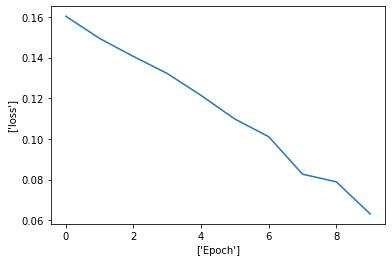

In [137]:
plt.plot(range(len(model_1.history.history['loss'])), model_1.history.history['loss'])
plt.xlabel(['Epoch'])
plt.ylabel(['loss'])

In [138]:
model_1.evaluate(X_train, y_train)

484/484 [==============================] - 16s 33ms/step - loss: 0.0495


0.04953577741980553

In [139]:
predictions_1=model_1.predict(X_test_ts)
predictions_1

array([[6.6692144e-02],
       [7.2837949e-02],
       [6.5295018e-07],
       ...,
       [1.1967284e-05],
       [1.4396901e-05],
       [2.0941396e-05]], dtype=float32)

In [140]:
threshold = 0.2

print('Outputs shape')    
print(predictions_1.shape) # prints (n,1) but  need (n,)
predictions_1=np.transpose(predictions_1)[0]  # transformation to get (n,)
print(predictions_1.shape)  # now the shape is (n,)
# Applying transformation to get binary values predictions with  thresold
predictions_1 = list(map(lambda x: 0 if x<threshold else 1, predictions_1))

Outputs shape
(8289, 1)
(8289,)


In [141]:
dset_sol_lr_1 = pd.DataFrame({"HADM_ID": test_2.HADM_ID, "Prediction" : predictions_1})
dset_sol_lr_1.head()

,HADM_ID,Prediction
0,88439,0
1,85430,0
2,33620,0
3,108726,0
4,71197,0


Text(0, 0.5, "['loss']")

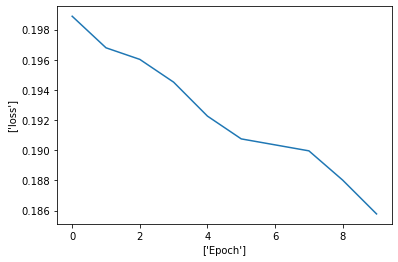

In [142]:
plt.plot(range(len(model_2.history.history['loss'])), model_2.history.history['loss'])
plt.xlabel(['Epoch'])
plt.ylabel(['loss'])

In [143]:
model_2.evaluate(X_train, y_train)

484/484 [==============================] - 1s 1ms/step - loss: 0.1865


0.1864832043647766

In [144]:
predictions_2=model_2.predict(X_test_ts)
predictions_2

array([[7.88062811e-04],
       [1.52394176e-03],
       [2.24070318e-05],
       ...,
       [1.22413927e-04],
       [4.26918268e-04],
       [1.08161556e-04]], dtype=float32)

In [145]:
threshold = 0.2

print('Outputs shape')    
print(predictions_2.shape) # prints (n,1) but  need (n,)
predictions_2=np.transpose(predictions_2)[0]  # transformation to get (n,)
print(predictions_2.shape)  # now the shape is (n,)
# Applying transformation to get binary values predictions with  thresold
predictions_2 = list(map(lambda x: 0 if x<threshold else 1, predictions_2))

Outputs shape
(8289, 1)
(8289,)


In [146]:
dset_sol_lr_2 = pd.DataFrame({"HADM_ID": test_2.HADM_ID, "Prediction" : predictions_2})
dset_sol_lr_2.head()

,HADM_ID,Prediction
0,88439,0
1,85430,0
2,33620,0
3,108726,0
4,71197,0


Text(0, 0.5, "['loss']")

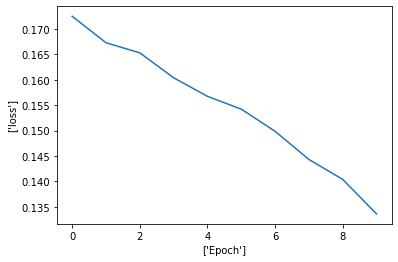

In [147]:
plt.plot(range(len(model_3.history.history['loss'])), model_3.history.history['loss'])
plt.xlabel(['Epoch'])
plt.ylabel(['loss'])

In [148]:
model_3.evaluate(X_train, y_train)

484/484 [==============================] - 2s 5ms/step - loss: 0.1198


0.11984003335237503

In [149]:
predictions_3=model_3.predict(X_test_ts)
predictions_3

array([[3.4891129e-02],
       [9.0893626e-02],
       [2.0131469e-04],
       ...,
       [8.1470243e-05],
       [4.3609738e-04],
       [4.0769577e-04]], dtype=float32)

In [150]:
threshold = 0.2

print('Outputs shape')    
print(predictions_3.shape) # prints (n,1) but  need (n,)
predictions_3=np.transpose(predictions_3)[0]  # transformation to get (n,)
print(predictions_3.shape)  # now the shape is (n,)
# Applying transformation to get binary values predictions with thresold
predictions_3 = list(map(lambda x: 0 if x<threshold else 1, predictions_3))

Outputs shape
(8289, 1)
(8289,)


In [151]:
dset_sol_lr_3 = pd.DataFrame({"HADM_ID": test_2.HADM_ID, "Prediction" : predictions_3})
dset_sol_lr_3.head()

,HADM_ID,Prediction
0,88439,0
1,85430,0
2,33620,0
3,108726,0
4,71197,0


In [152]:
dset_sol_rff.to_csv("prediction_MLGURU1.csv", index=False)  #random Forest
dset_sol_lr_1.to_csv("prediction_MLGURU2.csv", index=False)   #LSTM
dset_sol_lr_2.to_csv("prediction_MLGURU3.csv", index=False)    #CNN
dset_sol_lr_3.to_csv("prediction_MLGURU4.csv", index=False)     #CNN with LSTM